# Reinforcement Learning

# 6. Bandit Algorithms

This notebook presents **multi-armed bandit** algorithms.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from model import Environment
from agent import Agent

## Multi-Armed Bandit

Multi-armed bandits are single-state models with random rewards.

In [3]:
class MAB(Environment):
    """Multi-Armed Bandit environnement.
    
    Parameters
    ----------
    distribution: string
        Reward distribution (Bernoulli, Uniform or Gaussian)
    params: list
        List of parameters (one per action)
        Example for Bernoulli (mean): [0.4, 0.5, 0.6]
        Example for Uniform (low, high): [(-1, 1), (0, 1), (-1, 2)]
        Example for Gaussian (mean, variance): [(0, 1), (1, 2), (-1, 1)]
    """

    def __init__(self, distribution='bernoulli', params=[0.4, 0.6]):        
        if type(distribution) != str:
            raise ValueError("The parameter 'distribution' must be a string: either 'bernoulli', 'uniform' or 'gaussian'.")
        self.distribution = distribution.lower()
        self.params = params
         
    @staticmethod
    def get_states():
        """Single state."""
        return [None]
    
    def get_actions(self):
        """One action per arm."""
        actions = [action for action, _ in enumerate(self.params)]
        return actions
    
    def get_reward(self, action):
        """Random reward. The parameter depends on the action."""
        if self.distribution == 'bernoulli':
            return np.random.random() < self.params[action]
        if self.distribution == 'uniform':
            low, high = self.params[action]
            return np.random.uniform(low, high)
        if self.distribution in ['gaussian', 'normal']:
            mean, std = self.params[action]
            return np.random.normal(mean, std)
        raise ValueError('Unknown distribution.')
        
    def get_model(self):
        raise ValueError('Not available.')
        
    def step(self, action):
        stop = False
        reward = self.get_reward(action)
        return reward, stop

In [4]:
class Bandit(Agent):
    """Bandit algorithm with random policy. 

    Parameters
    ----------
    model : object of class MAB
        The model.
    init_value : float
        Initial value of the action-value function.
    init_count : int
        Initial count of the action-count function.
    """
    
    def __init__(self, model, init_value=0, init_count=0):
        if not isinstance(model, MAB):
            raise ValueError('The model must be a multi-armed bandit.')
        self.model = model
        self.policy = self.random_policy
        actions = model.get_actions()
        self.values = len(actions) * [init_value]
        self.counts = len(actions) * [init_count]

    def get_actions(self, state=None):
        """Get all possible actions."""
        return self.model.get_actions()
    
    def get_episode(self, horizon=100):
        """Get the rewards for an episode and update the values."""
        state = None
        rewards = []
        for t in range(horizon):
            action = self.get_action(state)
            reward, _ = self.model.step(action)
            rewards.append(reward)
            self.counts[action] += 1
            diff = reward - self.values[action]
            # update by temporal difference
            self.values[action] += diff / self.counts[action]
        return rewards    

In [5]:
model = MAB()

In [6]:
model.distribution

'bernoulli'

In [7]:
model.params

[0.4, 0.6]

In [8]:
agent = Bandit(model)

In [9]:
agent.get_actions()

[0, 1]

In [10]:
rewards = agent.get_episode(horizon=100)

In [11]:
np.mean(rewards)

0.39

In [12]:
agent.values

[0.29629629629629634, 0.49999999999999983]

In [13]:
agent.counts

[54, 46]

## The $\varepsilon$-greedy policy

In [14]:
class Greedy(Bandit):
    """Bandit algorithm with epsilon-greedy policy. 

    Parameters
    ----------
    model : object of class MAB
        The model.
    epsilon : float in [0, 1]
        Exploration rate.
    init_value : float
        Initial value of the action-value function.
    init_count : int
        Initial count of the action-count function.
    """
    
    def __init__(self, model, epsilon=0.1, init_value=0, init_count=0):
        super(Greedy, self).__init__(model, init_value, init_count) 
        self.epsilon = epsilon

    def get_action(self, state=None):
        """Get action with eps-greedy policy."""
        actions = self.get_actions()
        if np.random.random() > self.epsilon:
            # select the best action(s) with probability 1 - epsilon
            values = np.array(self.values)
            actions = np.flatnonzero(values==np.max(values))
        return np.random.choice(actions)


In [15]:
agent = Greedy(model)

In [16]:
rewards = agent.get_episode(horizon=100)

In [ ]:
np.mean(rewards)

In [ ]:
agent.values

In [ ]:
agent.counts

## To do 

* Compute the expected **gain** for $\varepsilon = 0.2$ and check your result by simulation.<br>**Hint:** You might adapt the time horizon.
* Observe the phenomenon of **optimism in face of incertainty** when $\varepsilon = 0$.<br>**Hint:** You might adapt the parameters ``init_value`` and ``init_count``.

#### $\epsilon=0.2$

Computation:

$P(A)=\epsilon\times\frac{1}{2}=0.1$

$P(B)=1-\epsilon + \epsilon\times\frac{1}{2}=0.9$

$\mathbb{E}(A)=0.4$ and $\mathbb{E}(B)=0.6$

$\mathbb{E}(G)=P(A)\times\mathbb{E}(A)+P(B)\times\mathbb{E}(B)=0.1\times 0.4+0.9\times 0.6=0.58$

Simulation:

In [ ]:
agent = Greedy(model, epsilon=0.2)
rewards = agent.get_episode(horizon=10000)
np.mean(rewards)

#### $\epsilon=0$

In [ ]:
agent = Greedy(model, epsilon=0, init_value=1, init_count=1)
rewards = agent.get_episode(horizon=10000)
np.mean(rewards)

## The UCB policy

We now consider the UCB (Upper Confidence Bound) policy.

## To do

* Complete and test the agent ``UCB`` below.
* Plot the **regret** with respect to the time horizon, and compare with the $\varepsilon$-greedy policy for different values of $\varepsilon$.
* Repeat this experiment for the other models (uniform and Gaussian).<br> Interpret the results.
* Test the impact of the number of actions.

In [16]:
class UCB(Bandit):
    """Bandit algorithm with UCB policy. 

    Parameters
    ----------
    model : object of class MAB
        The model.
    const : float in [0, 1]
        Multiplicative constant for the UCB bonus.
    init_value : float
        Initial value of the action-value function.
    init_count : int
        Initial count of the action-count function.
    """
    
    def __init__(self, model, const=1, init_value=0, init_count=0):
        super(UCB, self).__init__(model, init_value, init_count) 
        self.const = const

    def get_action(self, state=None):
        """Get action with UCB policy."""
        values = np.array(self.values)
        counts = np.array(self.counts)
        actions = self.get_actions()
        # to be modified
        ucb_values = values + self.const * np.sqrt(np.log(np.sum(counts) + 1) / (counts + 1e-6))
        return actions[np.argmax(ucb_values)]


In [ ]:
agent = UCB(model)
rewards = agent.get_episode(horizon=10000)
np.mean(rewards)

In [18]:
def calculate_regret(model, agent, horizon):
    optimal_reward = [np.max(model.params)] * horizon
    rewards = agent.get_episode(horizon)
    return np.cumsum(optimal_reward - np.array(rewards))

Bernoulli

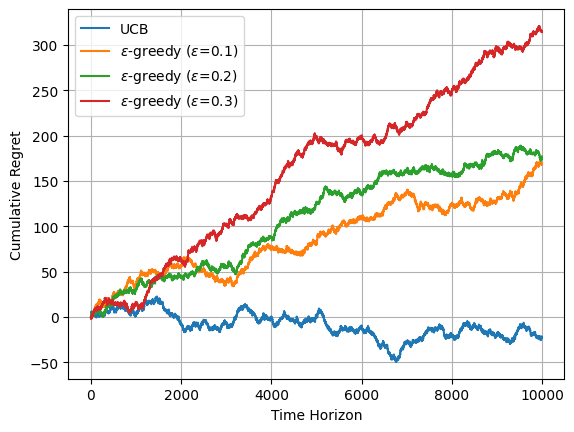

In [19]:
model = MAB()
epsilons = [0.1, 0.2, 0.3]

agent_UCB = UCB(model)
regrets_UCB = calculate_regret(model, agent_UCB, horizon=10000)

regrets_eps = []
for epsilon in epsilons:
    agent_eps = Greedy(model, epsilon=epsilon)
    regrets_eps.append(calculate_regret(model, agent_eps, horizon=10000))

plt.plot(regrets_UCB, label="UCB")
for i, epsilon in enumerate(epsilons):
    plt.plot(regrets_eps[i], label=f"$\epsilon$-greedy ($\epsilon$={epsilon})")
plt.xlabel("Time Horizon")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.grid()
plt.show()

Uniform

In [ ]:
model = MAB(distribution='uniform', params=[(0.1, 0.7), (0.3, 0.8)])
epsilons = [0.1, 0.2, 0.3]

agent_UCB = UCB(model)
regrets_UCB = calculate_regret(model, agent_UCB, horizon=10000)

regrets_eps = []
for epsilon in epsilons:
    agent_eps = Greedy(model, epsilon=epsilon)
    regrets_eps.append(calculate_regret(model, agent_eps, horizon=10000))

plt.plot(regrets_UCB, label="UCB")
for i, epsilon in enumerate(epsilons):
    plt.plot(regrets_eps[i], label=f"$\epsilon$-greedy ($\epsilon$={epsilon})")
plt.xlabel("Time Horizon")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.grid()
plt.show()

Gaussian

In [ ]:
model = MAB(distribution='gaussian', params=[(0.4, 0.01), (0.5, 1)])
epsilons = [0.1, 0.2, 0.3]

agent_UCB = UCB(model)
regrets_UCB = calculate_regret(model, agent_UCB, horizon=10000)

regrets_eps = []
for epsilon in epsilons:
    agent_eps = Greedy(model, epsilon=epsilon)
    regrets_eps.append(calculate_regret(model, agent_eps, horizon=10000))

plt.plot(regrets_UCB, label="UCB")
for i, epsilon in enumerate(epsilons):
    plt.plot(regrets_eps[i], label=f"$\epsilon$-greedy ($\epsilon$={epsilon})")
plt.xlabel("Time Horizon")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.grid()
plt.show()

Interpretation:

It seems that UCB performs better than $\epsilon$-greedy.

In fact, UCB outperforms $\epsilon$-greedy because it dynamically balances exploration and exploitation by focusing on actions with high uncertainty, thanks to its optimism-based approach. Unlike $\epsilon$-greedy, which explores randomly, UCB efficiently targets potentially optimal actions, avoiding unnecessary trials. This adaptiveness leads to better sample efficiency and lower regret over time.

In [20]:
for params in [[0.7,0.9],
               [0.5,0.7,0.9],
               [0.3,0.5,0.7,0.9]]:
    model = MAB(distribution='bernoulli', params=params)
    agent = UCB(model)
    rewards = agent.get_episode(horizon=10000)
    print(f"Action number: {len(params)}, Rewards: {np.mean(rewards)}, Regret: {calculate_regret(model, agent, horizon=10000)[-1]}")

Action number: 2, Rewards: 0.8954, Regret: -11.000000000001386
Action number: 3, Rewards: 0.8931, Regret: -29.00000000000859
Action number: 4, Rewards: 0.8878, Regret: 45.99999999999203


In [50]:
for params in [[0.8,0.5,0.2],
               [0.8,0.5,0.5],
               [0.8,0.8,0.5],
               [0.8,0.7,0.5]]:
    model = MAB(distribution='bernoulli', params=params)
    agent = Greedy(model, epsilon=0.01)
    rewards = agent.get_episode(horizon=10000)
    print(f"Action number: {len(params)}, Rewards: {np.mean(rewards)}")

Action number: 3, Rewards: 0.7981
Action number: 3, Rewards: 0.8007
Action number: 3, Rewards: 0.7949
Action number: 3, Rewards: 0.7905


Regret generally increases when the number of actions increases. This happens because UCB must explore each action sufficiently to estimate its reward distribution, and with more actions, the exploration phase becomes longer. As a result, more suboptimal actions are tried before settling on the optimal one, leading to higher cumulative regret.

## Thompson sampling

Finally, we consider Thompson Sampling, where the mean rewards are considered as random and sampled according to the posterior distribution (Bayesian algorithm).

## To do

* Complete and test the agent ``TS`` below.
* Plot the **regret** with respect to the time horizon, and compare with the UCB policy for different models.
* Which algorithm is the more efficient?<br> Comment your results.

In [93]:
class TS(Bandit):
    """Bandit algorithm with Thompson sampling. 

    Parameters
    ----------
    model : object of class MAB
        The model.
    """
    
    def __init__(self, model):
        super(TS, self).__init__(model) 
        self.distribution = model.distribution
            
    def get_action(self, state=None):
        """Get action with TS policy."""
        values = np.array(self.values)
        counts = np.array(self.counts)
        if self.distribution == 'bernoulli':
            # to be modified
            samples = np.array([
                np.random.beta(value * count + 1, count - value * count + 1)
                for value, count in zip(values, counts)
            ])
        elif self.distribution == 'uniform':
            # to be modified
            samples = np.array([
                np.random.uniform(low, high)
                for (low, high) in self.model.params
            ])
        elif self.distribution == 'gaussian':
            # to be modified
            samples = np.array([
                np.random.normal(mean, np.sqrt(var))
                for (mean, var) in self.model.params
            ])
        return np.argmax(samples)


In [ ]:
model = MAB(distribution='bernoulli', params=[0.4, 0.6])
agent = TS(model)
rewards = agent.get_episode(horizon=10000)
np.mean(rewards)

Bernoulli

In [ ]:
model = MAB()
agent_UCB = UCB(model)
regrets_UCB = calculate_regret(model, agent_UCB, horizon=10000)

agent_TS = TS(model)
regrets_TS = calculate_regret(model, agent_TS, horizon=10000)

plt.plot(regrets_UCB, label="UCB")
plt.plot(regrets_TS, label="TS")
plt.xlabel("Time Horizon")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.grid()
plt.show()

Uniform

In [ ]:
model = MAB(distribution='uniform', params=[(0.1, 0.7), (0.3, 0.8)])
agent_UCB = UCB(model)
regrets_UCB = calculate_regret(model, agent_UCB, horizon=10000)

agent_TS = TS(model)
regrets_TS = calculate_regret(model, agent_TS, horizon=10000)

plt.plot(regrets_UCB, label="UCB")
plt.plot(regrets_TS, label="TS")
plt.xlabel("Time Horizon")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.grid()
plt.show()

Gaussian

In [ ]:
model = MAB(distribution='gaussian', params=[(0.4, 0.01), (0.5, 1)])
agent_UCB = UCB(model)
regrets_UCB = calculate_regret(model, agent_UCB, horizon=10000)

agent_TS = TS(model)
regrets_TS = calculate_regret(model, agent_TS, horizon=10000)

plt.plot(regrets_UCB, label="UCB")
plt.plot(regrets_TS, label="TS")
plt.xlabel("Time Horizon")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.grid()
plt.show()